In [61]:
import torch
import pandas as pd
from torch.utils.data import Dataset , DataLoader
import numpy as np
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import  create_experiment_folder
import os

In [62]:
torch.__version__

'2.2.1'

In [63]:
ok_gesture=pd.read_csv("./csv/ok.csv")
yes_gesture=pd.read_csv("./csv/yes.csv")
zero_gesture=pd.read_csv("./csv/zero.csv")
call_gesture=pd.read_csv("./csv/call.csv")
five_gesture=pd.read_csv("./csv/five.csv")
one_gesture=pd.read_csv("./csv/one.csv")
rock_gesture=pd.read_csv("./csv/rock.csv")
love_gesture=pd.read_csv("./csv/love.csv")

In [64]:
ok_gesture["gesture"]="ok"
yes_gesture["gesture"]="yes"
zero_gesture["gesture"]="zero"
call_gesture["gesture"]="call"
five_gesture["gesture"]="five"
one_gesture["gesture"]="one"
rock_gesture["gesture"]="rock"
love_gesture["gesture"]="love"


In [65]:
train_dataset=pd.concat([ok_gesture.iloc[0:80,:],call_gesture.iloc[0:80,:],
                         five_gesture.iloc[0:80,:],rock_gesture.iloc[0:80,:],
                         yes_gesture.iloc[0:80,:],zero_gesture.iloc[0:80,:],
                         one_gesture.iloc[0:80,:],love_gesture.iloc[0:80,:]],axis=0)

valid_dataset=pd.concat([ok_gesture.iloc[80:,:],call_gesture.iloc[80:,:],
                         five_gesture.iloc[80:,:],rock_gesture.iloc[80:,:],
                         yes_gesture.iloc[80:,:],zero_gesture.iloc[80:,:],
                         one_gesture.iloc[80:,:],love_gesture.iloc[80:,:]],axis=0)

In [66]:
train_dataset.describe()

,1w,1x,1y,1z,2w,2x,2y,2z,3w,3x,...,4y,4z,5w,5x,5y,5z,6w,6x,6y,6z
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,...,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,0.680868,0.444212,0.194902,-0.083684,0.482260,0.037983,0.065109,-0.016899,0.383770,-0.224236,...,-0.097230,-0.078783,0.540888,-0.427375,-0.068199,0.056125,0.710243,0.595227,-0.060364,0.084543
std,0.222951,0.432057,0.162752,0.178034,0.272622,0.711097,0.289214,0.314679,0.282018,0.747637,...,0.237288,0.301862,0.281561,0.528156,0.268926,0.295386,0.209936,0.224666,0.125496,0.142742
min,0.010733,-0.879133,-0.216999,-0.634326,-0.012170,-0.999522,-0.631354,-0.676226,-0.013249,-0.999944,...,-0.679968,-0.674037,-0.015593,-0.995405,-0.668391,-0.615134,0.021086,-0.915720,-0.457970,-0.401166
25%,0.544554,0.106266,0.083120,-0.197017,0.275814,-0.721162,-0.103989,-0.268406,0.124190,-0.876250,...,-0.193560,-0.301566,0.287158,-0.830162,-0.244417,-0.164357,0.538303,0.454915,-0.147966,-0.011587
50%,0.706579,0.632133,0.168485,-0.091440,0.484394,-0.000322,0.052998,-0.051777,0.342208,-0.640108,...,-0.084560,-0.113783,0.584709,-0.640207,-0.029167,0.074885,0.783920,0.586885,-0.045791,0.034229
75%,0.858487,0.772912,0.286596,0.010543,0.703879,0.797996,0.245369,0.282419,0.629755,0.649235,...,0.007821,0.129517,0.794212,-0.167084,0.110779,0.287433,0.878515,0.787850,0.020157,0.164331
max,0.998440,0.990957,0.660559,0.642290,0.999101,0.999907,0.695531,0.687305,0.991465,0.999261,...,0.578039,0.674976,0.994355,0.997932,0.543820,0.666804,0.998437,0.982811,0.413545,0.563559


In [67]:
gesture_labels=sorted(list(set(train_dataset["gesture"])))
n_classes=len(gesture_labels)
print(n_classes)
print(gesture_labels)

8
['call', 'five', 'love', 'ok', 'one', 'rock', 'yes', 'zero']


In [68]:
class_to_num=dict(zip(gesture_labels,range(n_classes)))
num_to_class={v:k for k,v in class_to_num.items()}

In [69]:
print(class_to_num)
print(num_to_class)

{'call': 0, 'five': 1, 'love': 2, 'ok': 3, 'one': 4, 'rock': 5, 'yes': 6, 'zero': 7}
{0: 'call', 1: 'five', 2: 'love', 3: 'ok', 4: 'one', 5: 'rock', 6: 'yes', 7: 'zero'}


In [70]:
class Gesturedataset(Dataset):

    def __init__(self,data_frame,mode="train") -> None:
        self.reallen=len(data_frame)-1
        
        if mode =="train":
            self.mode="train"
            # tensor geshi shuju label feature fenkai
            self.train_data=torch.tensor(data_frame.iloc[1:,0:-1].values)
            self.train_label=np.asarray(data_frame.iloc[1:,-1].values)

        elif mode == "valid":
            self.mode="valid"
            self.valid_data=torch.tensor(data_frame.iloc[1:,0:-1].values)
            self.valid_label=np.asarray(data_frame.iloc[1:,-1].values)
        print("the {} mode of gesture data. {} samples found".format(mode,self.reallen))

    def __getitem__(self, index) :

        if self.mode == "train":
            quaternion_6part=self.train_data[index]
            label=self.train_label[index]
            number_label=class_to_num[label]
            return quaternion_6part,number_label
        else:
            quaternion_6part=self.valid_data[index]
            label=self.valid_label[index]
            number_label=class_to_num[label]
            return quaternion_6part,number_label

    
    def __len__(self):
        return self.reallen

In [71]:
train_dataset_forload=Gesturedataset(train_dataset,mode="train")
valid_dataset_forload=Gesturedataset(valid_dataset,mode="valid")

the train mode of gesture data. 639 samples found
the valid mode of gesture data. 159 samples found


In [72]:
qua,label=train_dataset_forload[300]
print(qua,label)

tensor([ 0.7646,  0.6035,  0.1848, -0.1306,  0.2201,  0.8770,  0.1138, -0.4117,
         0.3223,  0.6745, -0.2820,  0.6014,  0.7408, -0.0889, -0.6606, -0.0829,
         0.3100, -0.8230,  0.1566,  0.4496,  0.7899,  0.5856,  0.1528, -0.0986],
       dtype=torch.float64) 5


In [73]:
train_loader=DataLoader(train_dataset_forload,batch_size=16,shuffle=True)
valid_loader=DataLoader(valid_dataset_forload,batch_size=16,shuffle=True)

In [15]:
device='cpu'

In [82]:
class MLP(nn.Module):
    def __init__(self) :
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(24,48),nn.ReLU(),
            nn.Linear(48,24),nn.ReLU(),
            nn.Linear(24,12),nn.ReLU(),
            nn.Linear(12,8)
        )
        # 初始化模型的权重和偏置为 Float 类型
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                layer.weight.data = layer.weight.data.double()
                layer.bias.data = layer.bias.data.double()
                
    def forward (self,x):
        return self.net(x)

In [75]:
def train_one_epoch(model, device, train_loader, loss_fn, optimizer):
    model.train()  # 设置模型为训练模式
    train_loss, train_accuracy = [], []

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)
        loss = loss_fn(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=-1) == label).float().mean()
        train_loss.append(loss.item())
        train_accuracy.append(acc.item())

    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_train_accuracy = sum(train_accuracy) / len(train_accuracy)
    return avg_train_loss, avg_train_accuracy

In [76]:
def validate_one_epoch(model, device, valid_loader, loss_fn):
    model.eval()  # 设置模型为评估模式
    valid_loss, valid_accuracy = [], []
    
    with torch.no_grad():  # 关闭梯度计算
        for data, label in valid_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = loss_fn(output, label)

            acc = (output.argmax(dim=-1) == label).float().mean()
            valid_loss.append(loss.item())
            valid_accuracy.append(acc.item())

    avg_valid_loss = sum(valid_loss) / len(valid_loss)
    avg_valid_accuracy = sum(valid_accuracy) / len(valid_accuracy)
    return avg_valid_loss, avg_valid_accuracy

In [77]:
def plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies, exp_path):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Valid Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    img_path=os.path.join(exp_path,'loss.png')
    plt.savefig(img_path, format='png')  # 保存为 PNG 格式，300 dpi 的分辨率
    plt.show()

In [78]:
def plot_pca(exp_path,train_dataset,valid_dataset, model ,data="train"):
    """
    3 mode train valid all
    """
    if data == "train":
        dataset=train_dataset
    if data == "valid":
        dataset=valid_dataset
    elif data == "all":
        dataset=pd.concat([train_dataset,valid_dataset],axis=0)
    
    features = dataset.iloc[:, :-1].values
    labels = dataset.iloc[:, -1].values

    if class_to_num is not None:
        labels = np.array([class_to_num[label] for label in labels])
    
    features_tensor = torch.tensor(features).to(device)
    model.eval()
    with torch.no_grad():
        extracted_features = model(features_tensor).cpu().numpy()

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(extracted_features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('PCA of {} data'.format(data))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    img_name=data+".png"
    img_path=os.path.join(exp_path,img_name)
    plt.savefig(img_path,format='png')
    plt.show()

In [79]:
# CHAO CAN SHU
learning_rate = 0.03
weight_decay = 2e-3
num_epochs = 100
exp_path = create_experiment_folder()

In [83]:
# Train!!!!!
model=MLP()
model=model.to(device)

# loss and optim
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
    
for epoch in range(num_epochs):
    print(f"---------- Epoch {epoch + 1}/{num_epochs} ----------")

    train_loss, train_accuracy = train_one_epoch(model, device, train_loader, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"[Train] Loss: {train_loss:.5f}, Accuracy: {train_accuracy:.5f}")

    valid_loss, valid_accuracy = validate_one_epoch(model, device, valid_loader, loss_fn)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    print(f"[Valid] Loss: {valid_loss:.5f}, Accuracy: {valid_accuracy:.5f}")



---------- Epoch 1/100 ----------


[Train] Loss: 1.75917, Accuracy: 0.28042
[Valid] Loss: 1.47113, Accuracy: 0.34708
---------- Epoch 2/100 ----------
[Train] Loss: 0.92524, Accuracy: 0.57281
[Valid] Loss: 1.05394, Accuracy: 0.59250
---------- Epoch 3/100 ----------
[Train] Loss: 0.64079, Accuracy: 0.75292
[Valid] Loss: 0.64278, Accuracy: 0.79167
---------- Epoch 4/100 ----------
[Train] Loss: 0.44667, Accuracy: 0.82333
[Valid] Loss: 0.47104, Accuracy: 0.89333
---------- Epoch 5/100 ----------
[Train] Loss: 0.30878, Accuracy: 0.88594
[Valid] Loss: 0.34645, Accuracy: 0.90625
---------- Epoch 6/100 ----------
[Train] Loss: 0.21210, Accuracy: 0.92479
[Valid] Loss: 0.45277, Accuracy: 0.88125
---------- Epoch 7/100 ----------
[Train] Loss: 0.26789, Accuracy: 0.89500
[Valid] Loss: 0.43694, Accuracy: 0.87958
---------- Epoch 8/100 ----------
[Train] Loss: 0.15478, Accuracy: 0.94688
[Valid] Loss: 0.39471, Accuracy: 0.89292
---------- Epoch 9/100 ----------
[Train] Loss: 0.14279, Accuracy: 0.95312
[Valid] Loss: 0.45944, Accuracy

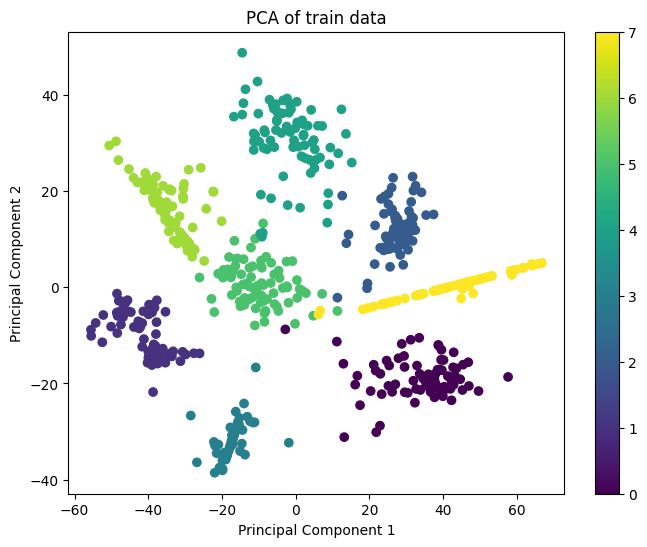

In [86]:
plot_pca(exp_path,train_dataset,valid_dataset,model,data="train")

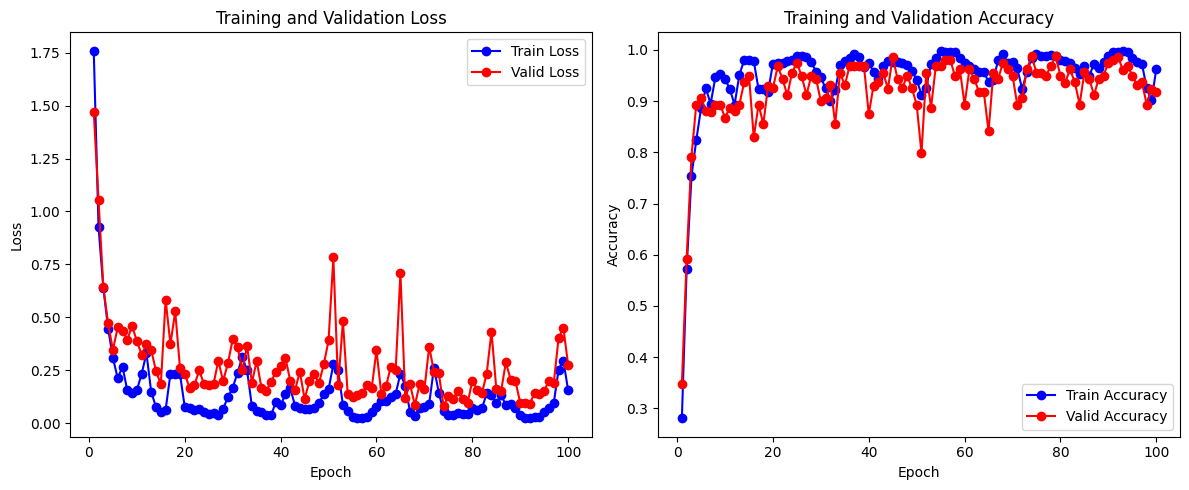

In [85]:
plot_metrics(train_losses,train_accuracies,valid_losses,valid_accuracies,exp_path)


In [54]:
model_path=os.path.join(exp_path,"model.ckpt")
torch.save(model.state_dict(),model_path)